In [211]:
import sys
import pickle
sys.path.append("../tools/")
import matplotlib.pyplot as plt
%matplotlib inline
## allow graph to be displayed
import pylab
import pandas as pd
import numpy as np
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.preprocessing import Imputer                                            
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from tester import test_classifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


In [212]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    del data_dict['TOTAL'] ## Wrong data, which explore before in the lesson, so I have save some effort to show why I delete it.

In [121]:
## Exploratory Step to show some basic information about the data.
count_poi=0
for name in data_dict:
    count_poi=count_poi+data_dict[name]['poi']  ## since poi is either 1 or 0, sum of it is the total numnber of poi
count_non_poi=len(data_dict)-count_poi
print "Number of POI : ", count_poi
print "Number of POI : ", count_non_poi

Number of POI :  18
Number of POI :  127


In [122]:
name_keys=data_dict.keys()
print name_keys


['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

In [123]:
df = pd.DataFrame(data_dict)
df = df.transpose()
feature_list=list(df.columns.values)
print feature_list

df.describe()
## the freq column shows the NaN frequency, since the data only have 145 data point
## A threshold that half of data is NaN which be throw away.

['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'email_address', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'poi', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,145,145,145,145,145,145,145,145,145,145,...,145,145,145,145,145,145,145,145,145,145
unique,41,39,44,17,112,101,94,65,58,42,...,52,92,2,97,18,94,84,87,125,124
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,64,107,97,129,34,44,51,59,59,59,...,80,53,127,36,128,51,59,59,21,20


In [124]:
df.isnull().sum()
##something weird, there should be a lot of NaN but it return 0

bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
email_address                0
exercised_stock_options      0
expenses                     0
from_messages                0
from_poi_to_this_person      0
from_this_person_to_poi      0
loan_advances                0
long_term_incentive          0
other                        0
poi                          0
restricted_stock             0
restricted_stock_deferred    0
salary                       0
shared_receipt_with_poi      0
to_messages                  0
total_payments               0
total_stock_value            0
dtype: int64

## I find out it is because the NaN in the dataframe is store as type"str" , that's why isnull() is not working.

In [125]:
print type(df['bonus'][1])
print df['bonus'][1]

<type 'str'>
NaN


In [126]:
## Change the NaN to numpy nan instead and rerun the code
df.replace(to_replace='NaN', value=np.nan, inplace=True)
df.isnull().sum()

bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                 34
exercised_stock_options       44
expenses                      51
from_messages                 59
from_poi_to_this_person       59
from_this_person_to_poi       59
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       59
to_messages                   59
total_payments                21
total_stock_value             20
dtype: int64

In [127]:
drop_list=df.isnull().sum().index.values[ np.array(df.isnull().sum() > 80) ]
print drop_list

['deferral_payments' 'deferred_income' 'director_fees' 'loan_advances'
 'restricted_stock_deferred']


In [128]:
df=df.drop(drop_list,axis=1)
df=df.drop('email_address',axis=1)
df.describe()
## The amil address won't be useful for the analysis


,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,8.100000e+01,1.010000e+02,94.000000,86.000000,86.000000,86.000000,6.500000e+01,9.200000e+01,1.090000e+02,9.400000e+01,86.000000,86.000000,1.240000e+02,1.250000e+02
mean,1.201773e+06,2.959559e+06,54192.010638,608.790698,64.895349,41.232558,7.464912e+05,4.652767e+05,1.147424e+06,2.840875e+05,1176.465116,2073.860465,2.623421e+06,3.352073e+06
std,1.441679e+06,5.499450e+06,46108.377454,1841.033949,86.979244,100.073111,8.629174e+05,1.389719e+06,2.249770e+06,1.771311e+05,1178.317641,2582.700981,9.488106e+06,6.532883e+06
min,7.000000e+04,3.285000e+03,148.000000,12.000000,0.000000,0.000000,6.922300e+04,2.000000e+00,-2.604490e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,8.000000e+06,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,5.145434e+06,1.035973e+07,1.476169e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07


In [129]:
df.corr()
## There are certainly some data are highly correlated, which is a sign that I should not use both data
## However, it is hard to say which features should be used, I am considering to apply PCA to transfrom data like
## bonus, salary to a "virtual feature" that kind of equal to "wealth", which may indicate that a POI.
## At this stage I will just keep all the features now and move on 

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
bonus,1.000000,0.506998,0.033799,0.052725,0.562187,0.354634,0.625259,0.376371,0.302384,0.376992,0.523190,0.549102,0.372997,0.569054,0.509441
exercised_stock_options,0.506998,1.000000,0.019412,-0.066129,0.160253,-0.030101,0.500016,0.536248,0.503551,0.690935,0.607324,0.154333,0.079568,0.591690,0.963560
expenses,0.033799,0.019412,1.000000,0.094144,-0.059244,0.014964,-0.100766,0.062874,0.060292,0.042896,0.145364,0.223495,0.155070,0.109798,0.034707
from_messages,0.052725,-0.066129,0.094144,1.000000,0.186708,0.588687,-0.071958,-0.101686,-0.074308,0.003145,-0.003541,0.230855,0.475450,-0.033089,-0.036310
from_poi_to_this_person,0.562187,0.160253,-0.059244,0.186708,1.000000,0.445063,0.212538,0.111249,0.167722,0.133594,0.179055,0.659264,0.525667,0.154431,0.146366
from_this_person_to_poi,0.354634,-0.030101,0.014964,0.588687,0.445063,1.000000,0.083591,-0.110335,0.112940,0.049284,0.021288,0.475748,0.568506,0.011556,0.001289
long_term_incentive,0.625259,0.500016,-0.100766,-0.071958,0.212538,0.083591,1.000000,0.529398,0.254723,0.635172,0.484114,0.178944,0.134277,0.518498,0.495485
other,0.376371,0.536248,0.062874,-0.101686,0.111249,-0.110335,0.529398,1.000000,0.120510,0.644357,0.606903,0.122591,0.040580,0.825444,0.627171
poi,0.302384,0.503551,0.060292,-0.074308,0.167722,0.112940,0.254723,0.120510,1.000000,0.224814,0.264976,0.228313,0.058954,0.230692,0.366462
restricted_stock,0.376992,0.690935,0.042896,0.003145,0.133594,0.049284,0.635172,0.644357,0.224814,1.000000,0.550824,0.232660,0.195570,0.595728,0.855250


In [130]:
df.describe()
## To examine is there any suspicious data, or extreme data

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,8.100000e+01,1.010000e+02,94.000000,86.000000,86.000000,86.000000,6.500000e+01,9.200000e+01,1.090000e+02,9.400000e+01,86.000000,86.000000,1.240000e+02,1.250000e+02
mean,1.201773e+06,2.959559e+06,54192.010638,608.790698,64.895349,41.232558,7.464912e+05,4.652767e+05,1.147424e+06,2.840875e+05,1176.465116,2073.860465,2.623421e+06,3.352073e+06
std,1.441679e+06,5.499450e+06,46108.377454,1841.033949,86.979244,100.073111,8.629174e+05,1.389719e+06,2.249770e+06,1.771311e+05,1178.317641,2582.700981,9.488106e+06,6.532883e+06
min,7.000000e+04,3.285000e+03,148.000000,12.000000,0.000000,0.000000,6.922300e+04,2.000000e+00,-2.604490e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,8.000000e+06,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,5.145434e+06,1.035973e+07,1.476169e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07


In [131]:
##Since I think there are two type of data here, one about money, one about email features. I think there is a need to seperate these 
##two types in different way.
## I have also learnt that money usually has a log normal distribution, directly apply it without rescale will limit the
## power of the algorithm.
## I will first explore the distribution of datas.


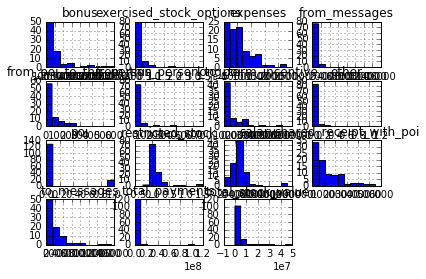

In [132]:
hist_plot=df.hist()
## These plot may load quite a bit time

In [133]:
### Before transfrom the data, I would like to create the new features for email feautres first
df['to_ratio']=df['from_poi_to_this_person']/df['from_messages']
df['from_ratio']=df['from_this_person_to_poi']/df['to_messages']


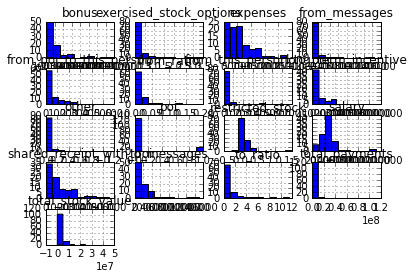

In [134]:
plt.figure()
df.hist()
plt.savefig('histogram.jpg')

In [135]:
##Remove poi from the dataframe to ease process
poi=df['poi']
df=df.drop('poi',axis=1)

In [136]:
df=np.log(df+1)

In [137]:
df=df.astype(float)
df.describe()

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,to_ratio,from_ratio
count,81.000000,101.000000,94.000000,86.000000,86.000000,86.000000,65.000000,92.000000,108.000000,94.000000,86.000000,86.000000,124.000000,124.000000,86.000000,86.000000
mean,13.558946,13.870899,10.380339,4.410550,3.236893,2.202892,13.055417,9.958508,13.199997,12.352743,6.286475,7.018999,13.500164,14.037766,0.516230,0.016677
std,0.915375,1.599002,1.333622,1.759714,1.673856,1.744033,0.966414,3.239753,1.164986,0.883363,1.636096,1.197984,1.964683,1.421200,0.588931,0.028983
min,11.156265,8.097426,5.003946,2.564949,0.000000,0.000000,11.145103,1.098612,10.387795,6.169611,1.098612,4.060443,5.003946,10.268096,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,15.894952,17.352066,12.340446,9.572828,6.270988,6.413459,15.453620,16.153437,16.507546,13.921004,8.616495,9.625756,18.455660,17.709575,2.527632,0.179732


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001DD78438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001E9E4828>]], dtype=object)

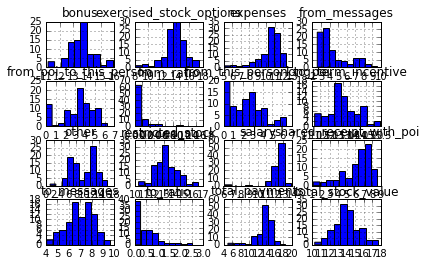

In [138]:
df.hist()
##show historgram again

In [139]:
## It is not perfect at this stage, but lots of variables show much "normal" distribution, which is good for applying machine learning.
##

In [140]:
########Start to prepare for the model
######## A scorer function to enhance the gridsearch later
from sklearn.metrics import make_scorer
def custom_scorer(labels, predictions):
    precision = precision_score(labels,predictions)
    recall = recall_score(labels,predictions )
    min_score = min(precision,recall)
    return min_score
scorer  = make_scorer(custom_scorer, greater_is_better=True)

In [141]:
from sklearn import svm
svr = svm.SVC(kernel='rbf', class_weight='balanced')
param_grid = {
         'C': [1,5,10,20,30,100,500,1000,5000],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
####Gridsearch parameter
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest

In [380]:
scorer  = make_scorer(custom_scorer, greater_is_better=True)
features_list = list(df.columns)
try:
    features_list.drop('poi')
except:
    pass
labels=poi
df.insert(0,'poi',poi)
##set up variable for the grader
features = df[features_list]
labels = poi
# put poi back in for udacity grader
print features_list
features.describe()

ValueError: cannot insert poi, already exists

In [144]:
## split the data into 2 set
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)


In [249]:
from sklearn.pipeline import Pipeline
# Build pipeline for the algorithm
Pipeline1 = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', GradientBoostingClassifier(random_state=0))
    ])

In [261]:
# estimator parameters
k = [8,10,12,14,16]
c = [4,6,8]
e = [100,50,25]
r = [0.001,0.01,0.1,1,10]
d = [d for d in range(6, 7)]
l = ["exponential"]

param_grid = {'selection__k': k,
              'pca__n_components': c,
              'imp__strategy': ['median','mean','most_frequent'],
              'clf__n_estimators': e,
              'clf__learning_rate': r,
           
              'clf__loss': l
             }

# set model parameters to grid search object
gridCV_object = GridSearchCV(estimator = Pipeline1, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,10, test_size=0.1,random_state=42))

# train the model
gridCV_object.fit(features_train, labels_train)

print gridCV_object.best_params_
print gridCV_object.scorer_

{'clf__n_estimators': 25, 'imp__strategy': 'most_frequent', 'pca__n_components': 4, 'clf__learning_rate': 10, 'clf__loss': 'exponential', 'selection__k': 14}
make_scorer(custom_scorer)


In [262]:
pred_CV = gridCV_object.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)

             precision    recall  f1-score   support

      False       0.93      0.93      0.93        40
       True       0.25      0.25      0.25         4

avg / total       0.86      0.86      0.86        44



In [ ]:
##try other classifier

In [255]:
# Build pipeline for the algorithm
Pipeline2 = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),random_state=0))
    ])

In [271]:
# estimator parameters
k = [8,10,12,14,16]
c = [4,6,8]
e = [100,50,25]
r = [0.001,0.01,0.1,1]



param_grid = {'selection__k': k,
              'pca__n_components': c,
              'imp__strategy': ['median','mean','most_frequent'],
              'clf__n_estimators': e,
              'clf__learning_rate': r,
              
             }

# set model parameters to grid search object
gridCV_object = GridSearchCV(estimator = Pipeline2, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,10, test_size=0.1,random_state=42))

# train the model
gridCV_object.fit(features_train, labels_train)

print gridCV_object.best_params_
print gridCV_object.scorer_
pred_CV = gridCV_object.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)

{'pca__n_components': 8, 'selection__k': 10, 'clf__learning_rate': 0.1, 'imp__strategy': 'most_frequent', 'clf__n_estimators': 100}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

      False       0.95      0.93      0.94        40
       True       0.40      0.50      0.44         4

avg / total       0.90      0.89      0.89        44



In [ ]:
# Build pipeline for the algorithm
Pipeline3 = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', svm.SVC(random_state=0))
    ])

In [264]:
# estimator parameters
k = [8,10,12,14,16]
c = [4,6,8]
r = [0.001,0.01,0.1,1,10,100,1000,10000,50000]
g = [0.001,0.01, 1,100,10000,50000]

param_grid = {'selection__k': k,
              'pca__n_components': c,
              'imp__strategy': ['median','mean','most_frequent'],
              'clf__C': r,
              'clf__gamma' : g
             }

# set model parameters to grid search object
gridCV_object = GridSearchCV(estimator = Pipeline3, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,10, test_size=0.1,random_state=42))

# train the model
gridCV_object.fit(features_train, labels_train)

print gridCV_object.best_params_
print gridCV_object.scorer_
pred_CV = gridCV_object.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)

{'clf__gamma': 1, 'pca__n_components': 4, 'selection__k': 12, 'clf__C': 50000, 'imp__strategy': 'most_frequent'}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

      False       0.92      0.88      0.90        40
       True       0.17      0.25      0.20         4

avg / total       0.85      0.82      0.83        44



In [ ]:
# Build pipeline for the algorithm
Pipeline4 = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', GaussianNB())
    ])

In [265]:
# estimator parameters
k = [8,10,12,14,16]
c = [4,6,8]



param_grid = {'selection__k': k,
              'pca__n_components': c,
            'imp__strategy': ['median','mean','most_frequent']
            
             
             }

# set model parameters to grid search object
gridCV_object = GridSearchCV(estimator = Pipeline4, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,10, test_size=0.1,random_state=42))

# train the model
gridCV_object.fit(features_train, labels_train)

print gridCV_object.best_params_
print gridCV_object.scorer_
pred_CV = gridCV_object.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)

{'pca__n_components': 4, 'selection__k': 8, 'imp__strategy': 'median'}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

      False       0.91      0.97      0.94        40
       True       0.00      0.00      0.00         4

avg / total       0.82      0.89      0.85        44



In [60]:
def data_preprocessing(data):
    
   
    with open(data, "r") as data_file:
        data_dict = pickle.load(data_file)
    df = pd.DataFrame(data_dict)
    df = df.transpose()
    df = df.drop('TOTAL') ## remove 

    ### Drop all the variable that I have done before, this function is aim to repeat the above process in a nice function.
    df = df.drop('email_address', axis=1)
    df = df.astype(float)
    drop_list=['deferral_payments' ,'deferred_income' ,'director_fees' ,'loan_advances', 'restricted_stock_deferred']
    df=df.drop(drop_list, axis=1)
    ###new variable added
    df['to_ratio'] = df['from_poi_to_this_person']/(df['from_messages'] )
    df['from_ratio'] = df['from_this_person_to_poi']/(df['from_messages'])
    df=df.drop('poi',axis=1)
 
    labels=df['poi']
    df=df.drop('poi',axis=1)
    df=np.log(df+1)
    features=df
    features_list=list(df.columns.values)
    features_list=featues_list.insert(0,'poi')
    
    return df, features, labels, features_list

In [ ]:
def get_train_test_split(features, labels):
    '''This gets the train test split for the sklearn runs of the model'''
    from sklearn import cross_validation
    features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
    return features_train, features_test, labels_train, labels_test

In [292]:
## I choose AdaboostClassifier to be my final choice as it seems to provide the highest performance
## and I have tune the parameter which perform best in the training sample
Pipeline_final = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),random_state=0))
    ])
# estimator parameters
k = [10]
c = [8]
e = [100]
r = [0.1]


param_grid={'selection__k': k,
              'pca__n_components': c,
              'imp__strategy': ['most_frequent'],
              'clf__n_estimators': e,
              'clf__learning_rate': r}

# set model parameters to grid search object
gridCV_object_final = GridSearchCV(estimator = Pipeline_final, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,1000, test_size=0.1,random_state=42))

# train the model
gridCV_object_final.fit(features_train, labels_train)

print gridCV_object_final.best_params_
print gridCV_object_final.scorer_
pred_CV = gridCV_object_final.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)
            


{'pca__n_components': 8, 'selection__k': 10, 'clf__learning_rate': 0.1, 'imp__strategy': 'most_frequent', 'clf__n_estimators': 100}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

      False       0.95      0.93      0.94        40
       True       0.40      0.50      0.44         4

avg / total       0.90      0.89      0.89        44



In [381]:
from  time import time

df1 = df.transpose()
df1 = df1.to_dict()
print "\n\nAnd these are the results going through the test classifier:\n"
## send the best parameter to clf
t0=time()
clf=gridCV_object_final.best_estimator_
test_classifier(clf, df1, features_list, folds = 1000)
t1=time()-t0
print t1



And these are the results going through the test classifier:

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectKBest(k=8, score_func=<function f_classif at 0x000000001FBFA3C8>)), ('pca', PCA(copy=True, n_components=6, whiten=False)), ('clf',...dom_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=100, random_state=0))])
	Accuracy: 0.80593	Precision: 0.26748	Recall: 0.26200	F1: 0.26471	F2: 0.26308
	Total predictions: 15000	True positives:  524	False positives: 1435	False negatives: 1476	True negatives: 11565

7.51999998093


## It was not too bad, but can not meet the 0.3 standard, so I am considering change some of the parameters.

In [294]:
print features_list

print clf

['poi', 'bonus', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'long_term_incentive', 'other', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value', 'to_ratio', 'from_ratio']
Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectKBest(k=10, score_func=<function f_classif at 0x000000001FBFA3C8>)), ('pca', PCA(copy=True, n_components=8, whiten=Fa...andom_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=100, random_state=0))])


In [ ]:
### I don't know why exactly the algorithm not working, and I think I should try to remove some features and only keep those 
### I have confidence help identify POI.
### Since some of the variable have correlation with each other, like exercised_stock_option and total_stock_value have 0.94 
### correlation, that is too high to use both variable, I will remove total_stock_value for this stage.
### since to_ratio and from_ratio must correlate with the original variable , and i will keep the ratio and dump others.
df2=df
df3=df
df=df.drop('total_stock_value',axis=1)
df=df.drop('from_this_person_to_poi',axis=1)
df=df.drop('from_poi_to_this_person',axis=1)
df=df.drop('from_messages',axis=1)
df=df.drop('to_messages',axis=1)

In [385]:
from sklearn.preprocessing import StandardScaler
Pipeline_final = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', AdaBoostClassifier(DecisionTreeClassifier(random_state=0)))
    ])
# estimator parameters
k = [6,8,10]
c = [3,4,5]
e = [100,50,25]
r = [0.001,0.01,0.1,1]


param_grid={'selection__k': k,
              'pca__n_components': c,
              'imp__strategy': ['mean','median','most_frequent'],
              'clf__n_estimators': e,
              'clf__learning_rate': r}

# set model parameters to grid search object
gridCV_object_final = GridSearchCV(estimator = Pipeline_final, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,10, test_size=0.1,random_state=42))

# train the model
t0=time()
gridCV_object_final.fit(features_train, labels_train)

print gridCV_object_final.best_params_
print gridCV_object_final.scorer_
pred_CV = gridCV_object_final.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)


t1=time()-t0
print t1            

{'pca__n_components': 3, 'selection__k': 10, 'clf__learning_rate': 0.1, 'imp__strategy': 'most_frequent', 'clf__n_estimators': 100}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

      False       0.95      0.88      0.91        40
       True       0.29      0.50      0.36         4

avg / total       0.89      0.84      0.86        44

81.8240001202


In [386]:
t0=time()
clf=gridCV_object_final.best_estimator_
test_classifier(clf, df1, features_list, folds = 1000)
t1=time()-t0
print t1       

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectKBest(k=10, score_func=<function f_classif at 0x000000001FBFA3C8>)), ('pca', PCA(copy=True, n_components=3, whiten=Fa...andom_state=0, splitter='best'),
          learning_rate=0.1, n_estimators=100, random_state=None))])
	Accuracy: 0.83760	Precision: 0.37500	Recall: 0.32700	F1: 0.34936	F2: 0.33559
	Total predictions: 15000	True positives:  654	False positives: 1090	False negatives: 1346	True negatives: 11910

22.368999958


In [387]:
## The classifier improve in this case, precision =0.375, recall= 0.327
## Right now the base classifier is with the above setting, remove"TOTAL" and other features, only these features is used
print features_list
## I am ok with this classifier setting now, but I just want to try one more thing

['poi', 'bonus', 'exercised_stock_options', 'expenses', 'long_term_incentive', 'other', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'total_payments', 'to_ratio', 'from_ratio']


print 1
fea =clf.named_steps['selection']
fea.get_support()

In [374]:
features_list

['poi',
 'bonus',
 'exercised_stock_options',
 'expenses',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'salary',
 'shared_receipt_with_poi',
 'total_payments',
 'to_ratio',
 'from_ratio']

# I doubt the imputer is not working well, since imputing mean,median,and mode will not work well I suspect in this case, it will mix with the data and the tree will not be able to distinguish . I want to try imputing 0 for NaN instead.

In [477]:

## repeat the process
from sklearn.preprocessing import StandardScaler
Pipeline_final = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', AdaBoostClassifier(DecisionTreeClassifier(random_state=0)))
    ])
# estimator parameters
k = [6,8,10]
c = [3,4,5]
e = [100,50,25]
r = [0.001,0.01,0.1,1]


param_grid={'selection__k': k,
              'pca__n_components': c,
              'imp__strategy': ['mean','median','most_frequent'],
              'clf__n_estimators': e,
              'clf__learning_rate': r}

# set model parameters to grid search object
gridCV_object_final = GridSearchCV(estimator = Pipeline_final, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,10, test_size=0.1,random_state=42))

# train the model
t0=time()
gridCV_object_final.fit(features_train, labels_train)

print gridCV_object_final.best_params_
print gridCV_object_final.scorer_
pred_CV = gridCV_object_final.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)


t1=time()-t0
print t1            

{'selection__k': 6, 'clf__learning_rate': 0.001, 'imp__strategy': 'mean', 'clf__n_estimators': 100}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

      False       1.00      1.00      1.00        40
       True       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00        44

34.5069999695


In [475]:
from  time import time

df1 = df.transpose()
df1 = df1.to_dict()
print "\n\nAnd these are the results going through the test classifier:\n"
## send the best parameter to clf
t0=time()
clf=gridCV_object_final.best_estimator_
test_classifier(clf, df1, features_list, folds = 1000)
t1=time()-t0
print t1



And these are the results going through the test classifier:

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectKBest(k=6, score_func=<function f_classif at 0x000000001FBFA3C8>)), ('pca', PCA(copy=True, n_components=3, whiten=False)), ('clf',...dom_state=0, splitter='best'),
          learning_rate=0.001, n_estimators=100, random_state=None))])
	Accuracy: 0.83293	Precision: 0.36280	Recall: 0.33450	F1: 0.34807	F2: 0.33980
	Total predictions: 15000	True positives:  669	False positives: 1175	False negatives: 1331	True negatives: 11825

5.28299999237


# The precision improve a little bit but the recall also go down a bit, no siginificant improvement

In [415]:
df.corr()

,poi,bonus,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,total_payments,to_ratio,from_ratio
poi,1.000000,0.278209,0.028941,0.302485,0.185085,0.320466,0.209955,0.252356,0.212734,0.211644,0.283283,0.168522
bonus,0.278209,1.000000,0.170409,0.555117,0.595299,0.621957,0.556634,0.858066,0.503231,0.620238,0.312372,0.234735
exercised_stock_options,0.028941,0.170409,1.000000,0.086261,0.232692,0.166330,0.267678,0.222878,0.253053,0.153160,0.066263,0.170774
expenses,0.302485,0.555117,0.086261,1.000000,0.317283,0.483555,0.309468,0.643142,0.264054,0.581069,0.190200,0.196573
long_term_incentive,0.185085,0.595299,0.232692,0.317283,1.000000,0.583468,0.389773,0.642647,0.361026,0.512252,0.227539,0.110188
other,0.320466,0.621957,0.166330,0.483555,0.583468,1.000000,0.467763,0.728005,0.273386,0.633602,0.219611,0.078627
restricted_stock,0.209955,0.556634,0.267678,0.309468,0.389773,0.467763,1.000000,0.566463,0.420250,0.229074,0.289204,0.149706
salary,0.252356,0.858066,0.222878,0.643142,0.642647,0.728005,0.566463,1.000000,0.450525,0.714850,0.285949,0.258474
shared_receipt_with_poi,0.212734,0.503231,0.253053,0.264054,0.361026,0.273386,0.420250,0.450525,1.000000,0.286577,0.538170,0.343546
total_payments,0.211644,0.620238,0.153160,0.581069,0.512252,0.633602,0.229074,0.714850,0.286577,1.000000,0.158330,0.175113


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001DF908D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000002499D908>]], dtype=object)

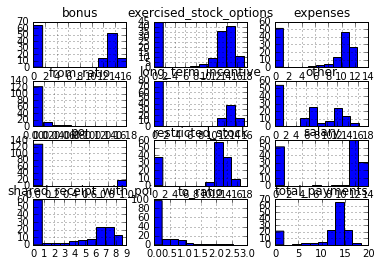

In [400]:
df.hist()

In [401]:
df3.describe()

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,to_ratio,from_ratio
count,81.000000,101.000000,94.000000,86.000000,86.000000,86.000000,65.000000,92.000000,108.000000,94.000000,86.000000,86.000000,124.000000,124.000000,86.000000,86.000000
mean,13.558946,13.870899,10.380339,4.410550,3.236893,2.202892,13.055417,9.958508,13.199997,12.352743,6.286475,7.018999,13.500164,14.037766,0.516230,0.016677
std,0.915375,1.599002,1.333622,1.759714,1.673856,1.744033,0.966414,3.239753,1.164986,0.883363,1.636096,1.197984,1.964683,1.421200,0.588931,0.028983
min,11.156265,8.097426,5.003946,2.564949,0.000000,0.000000,11.145103,1.098612,10.387795,6.169611,1.098612,4.060443,5.003946,10.268096,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,15.894952,17.352066,12.340446,9.572828,6.270988,6.413459,15.453620,16.153437,16.507546,13.921004,8.616495,9.625756,18.455660,17.709575,2.527632,0.179732


In [414]:
### I feel like I can seperate the preprocessing for financial data and email features.

array([False, False, False, False,  True, False,  True, False, False,
       False,  True, False, False, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False,  True,  True,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True,  True,  True, False, False,  True, False,
       False,  True, False, False, False,  True, False, False,  True,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False,  True,

In [422]:
df=df3

In [423]:
df=df.drop('total_stock_value',axis=1)
df=df.drop('from_this_person_to_poi',axis=1)
df=df.drop('from_poi_to_this_person',axis=1)
df=df.drop('from_messages',axis=1)
df=df.drop('to_messages',axis=1)

In [426]:
features

,poi,bonus,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,total_payments,to_ratio,from_ratio
ALLEN PHILLIP K,False,15.244625,14.363367,9.537411,12.627431,5.030438,11.744259,12.215805,7.249926,15.316125,0.021186,0.022151
BADUM JAMES P,False,NaN,12.460009,8.156797,NaN,NaN,NaN,NaN,NaN,12.114325,NaN,NaN
BANNANTINE JAMES M,False,NaN,15.213278,10.938485,NaN,13.669934,14.379433,6.169611,6.144186,13.727988,0.852212,0.000000
BAXTER JOHN C,False,13.997833,15.714710,9.323758,14.276761,14.793951,15.187380,12.495390,NaN,15.544391,NaN,NaN
BAY FRANKLIN R,False,12.899222,NaN,11.768676,NaN,4.248495,11.889971,12.387027,NaN,13.626402,NaN,NaN
BAZELIDES PHILIP J,False,NaN,14.285290,NaN,11.448398,6.774224,NaN,11.299967,NaN,13.664847,NaN,NaN
BECK SALLY W,False,13.458837,NaN,10.523338,NaN,6.340359,11.744259,12.351605,7.878534,13.784091,0.032619,0.051423
BELDEN TIMOTHY N,True,15.473739,13.767514,9.761694,NaN,12.258186,11.967625,12.273731,8.616495,15.520555,0.385993,0.013425
BELFER ROBERT,False,NaN,8.097426,NaN,NaN,NaN,NaN,NaN,NaN,11.537628,NaN,NaN
BERBERIAN DAVID,False,NaN,14.300647,9.383705,NaN,NaN,13.675353,12.285729,NaN,12.339182,NaN,NaN


In [472]:
df=df.drop('poi',axis=1)
df=df.drop('total_stock_value',axis=1)
df=df.drop('from_this_person_to_poi',axis=1)
df=df.drop('from_poi_to_this_person',axis=1)
df=df.drop('from_messages',axis=1)
df=df.drop('to_messages',axis=1)
features=df
features_list=list(df.columns.values)
features_list.insert(0,'poi')
df.insert(0,'poi',poi)

In [473]:
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)


In [445]:
features

,bonus,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,total_payments,to_ratio,from_ratio
ALLEN PHILLIP K,15.244625,14.363367,9.537411,12.627431,5.030438,11.744259,12.215805,7.249926,15.316125,0.021186,0.022151
BADUM JAMES P,0.000000,12.460009,8.156797,0.000000,0.000000,0.000000,0.000000,0.000000,12.114325,0.000000,0.000000
BANNANTINE JAMES M,0.000000,15.213278,10.938485,0.000000,13.669934,14.379433,6.169611,6.144186,13.727988,0.852212,-10.000000
BAXTER JOHN C,13.997833,15.714710,9.323758,14.276761,14.793951,15.187380,12.495390,0.000000,15.544391,0.000000,0.000000
BAY FRANKLIN R,12.899222,0.000000,11.768676,0.000000,4.248495,11.889971,12.387027,0.000000,13.626402,0.000000,0.000000
BAZELIDES PHILIP J,0.000000,14.285290,0.000000,11.448398,6.774224,0.000000,11.299967,0.000000,13.664847,0.000000,0.000000
BECK SALLY W,13.458837,0.000000,10.523338,0.000000,6.340359,11.744259,12.351605,7.878534,13.784091,0.032619,0.051423
BELDEN TIMOTHY N,15.473739,13.767514,9.761694,0.000000,12.258186,11.967625,12.273731,8.616495,15.520555,0.385993,0.013425
BELFER ROBERT,0.000000,8.097426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.537628,0.000000,0.000000
BERBERIAN DAVID,0.000000,14.300647,9.383705,0.000000,0.000000,13.675353,12.285729,0.000000,12.339182,0.000000,0.000000


In [471]:
df=df3
df=df.fillna(-1)
#df.replace(to_replace=0,value=-10,inplace= True)

In [460]:
df3

,poi,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,to_ratio,from_ratio
ALLEN PHILLIP K,False,15.244625,14.363367,9.537411,7.694393,3.871201,4.189655,12.627431,5.030438,11.744259,12.215805,7.249926,7.973500,15.316125,14.363367,0.021186,0.022151
BADUM JAMES P,False,NaN,12.460009,8.156797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.114325,12.460009,NaN,NaN
BANNANTINE JAMES M,False,NaN,15.213278,10.938485,3.401197,3.688879,0.000000,NaN,13.669934,14.379433,6.169611,6.144186,6.340359,13.727988,15.472497,0.852212,0.000000
BAXTER JOHN C,False,13.997833,15.714710,9.323758,NaN,NaN,NaN,14.276761,14.793951,15.187380,12.495390,NaN,NaN,15.544391,16.178556,NaN,NaN
BAY FRANKLIN R,False,12.899222,NaN,11.768676,NaN,NaN,NaN,NaN,4.248495,11.889971,12.387027,NaN,NaN,13.626402,11.051128,NaN,NaN
BAZELIDES PHILIP J,False,NaN,14.285290,NaN,NaN,NaN,NaN,11.448398,6.774224,NaN,11.299967,NaN,NaN,13.664847,14.285290,NaN,NaN
BECK SALLY W,False,13.458837,NaN,10.523338,8.376551,4.976734,5.958425,NaN,6.340359,11.744259,12.351605,7.878534,8.897819,13.784091,11.744259,0.032619,0.051423
BELDEN TIMOTHY N,True,15.473739,13.767514,9.761694,6.184149,5.433722,4.691348,NaN,12.258186,11.967625,12.273731,8.616495,8.986196,15.520555,13.920506,0.385993,0.013425
BELFER ROBERT,False,NaN,8.097426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.537628,NaN,NaN,NaN
BERBERIAN DAVID,False,NaN,14.300647,9.383705,NaN,NaN,NaN,NaN,NaN,13.675353,12.285729,NaN,NaN,12.339182,14.729245,NaN,NaN


In [449]:
features_list

['poi',
 'bonus',
 'exercised_stock_options',
 'expenses',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'salary',
 'shared_receipt_with_poi',
 'total_payments',
 'to_ratio',
 'from_ratio']

In [453]:
df.insert(0,'poi',poi)

In [454]:
df

,poi,bonus,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,total_payments,to_ratio,from_ratio
ALLEN PHILLIP K,False,15.244625,14.363367,9.537411,12.627431,5.030438,11.744259,12.215805,7.249926,15.316125,0.021186,0.022151
BADUM JAMES P,False,0.000000,12.460009,8.156797,0.000000,0.000000,0.000000,0.000000,0.000000,12.114325,0.000000,0.000000
BANNANTINE JAMES M,False,0.000000,15.213278,10.938485,0.000000,13.669934,14.379433,6.169611,6.144186,13.727988,0.852212,-10.000000
BAXTER JOHN C,False,13.997833,15.714710,9.323758,14.276761,14.793951,15.187380,12.495390,0.000000,15.544391,0.000000,0.000000
BAY FRANKLIN R,False,12.899222,0.000000,11.768676,0.000000,4.248495,11.889971,12.387027,0.000000,13.626402,0.000000,0.000000
BAZELIDES PHILIP J,False,0.000000,14.285290,0.000000,11.448398,6.774224,0.000000,11.299967,0.000000,13.664847,0.000000,0.000000
BECK SALLY W,False,13.458837,0.000000,10.523338,0.000000,6.340359,11.744259,12.351605,7.878534,13.784091,0.032619,0.051423
BELDEN TIMOTHY N,True,15.473739,13.767514,9.761694,0.000000,12.258186,11.967625,12.273731,8.616495,15.520555,0.385993,0.013425
BELFER ROBERT,False,0.000000,8.097426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.537628,0.000000,0.000000
BERBERIAN DAVID,False,0.000000,14.300647,9.383705,0.000000,0.000000,13.675353,12.285729,0.000000,12.339182,0.000000,0.000000


In [457]:
features

,poi,bonus,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,total_payments,to_ratio,from_ratio
ALLEN PHILLIP K,False,15.244625,14.363367,9.537411,12.627431,5.030438,11.744259,12.215805,7.249926,15.316125,0.021186,0.022151
BADUM JAMES P,False,0.000000,12.460009,8.156797,0.000000,0.000000,0.000000,0.000000,0.000000,12.114325,0.000000,0.000000
BANNANTINE JAMES M,False,0.000000,15.213278,10.938485,0.000000,13.669934,14.379433,6.169611,6.144186,13.727988,0.852212,-10.000000
BAXTER JOHN C,False,13.997833,15.714710,9.323758,14.276761,14.793951,15.187380,12.495390,0.000000,15.544391,0.000000,0.000000
BAY FRANKLIN R,False,12.899222,0.000000,11.768676,0.000000,4.248495,11.889971,12.387027,0.000000,13.626402,0.000000,0.000000
BAZELIDES PHILIP J,False,0.000000,14.285290,0.000000,11.448398,6.774224,0.000000,11.299967,0.000000,13.664847,0.000000,0.000000
BECK SALLY W,False,13.458837,0.000000,10.523338,0.000000,6.340359,11.744259,12.351605,7.878534,13.784091,0.032619,0.051423
BELDEN TIMOTHY N,True,15.473739,13.767514,9.761694,0.000000,12.258186,11.967625,12.273731,8.616495,15.520555,0.385993,0.013425
BELFER ROBERT,False,0.000000,8.097426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.537628,0.000000,0.000000
BERBERIAN DAVID,False,0.000000,14.300647,9.383705,0.000000,0.000000,13.675353,12.285729,0.000000,12.339182,0.000000,0.000000


In [494]:
n=0
for i in df.iterrows():
    for item in list(i:
        print item
            

ALLEN PHILLIP K
poi                            False
bonus                        15.2446
exercised_stock_options      14.3634
expenses                     9.53741
long_term_incentive          12.6274
other                        5.03044
restricted_stock             11.7443
salary                       12.2158
shared_receipt_with_poi      7.24993
total_payments               15.3161
to_ratio                   0.0211863
from_ratio                 0.0221512
Name: ALLEN PHILLIP K, dtype: object
BADUM JAMES P
poi                          False
bonus                           -1
exercised_stock_options      12.46
expenses                    8.1568
long_term_incentive             -1
other                           -1
restricted_stock                -1
salary                          -1
shared_receipt_with_poi         -1
total_payments             12.1143
to_ratio                        -1
from_ratio                      -1
Name: BADUM JAMES P, dtype: object
BANNANTINE JAMES M
poi            

In [468]:
features_train

,poi,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,to_ratio,from_ratio
HIRKO JOSEPH,True,NaN,17.241923,11.264195,NaN,NaN,NaN,NaN,7.957527,NaN,NaN,NaN,NaN,11.419647,17.241923,NaN,NaN
COX DAVID,False,13.592368,11.674636,10.235019,3.526361,0.000000,1.609438,NaN,6.204558,12.842869,12.658068,4.276666,4.634729,13.912087,13.113593,0.000000,0.038466
ECHOLS JOHN B,False,12.206078,13.307080,9.977249,NaN,NaN,NaN,14.619651,10.892583,12.917806,12.113113,NaN,NaN,14.805916,13.824413,NaN,NaN
LOWRY CHARLES P,False,NaN,12.827203,NaN,NaN,NaN,NaN,NaN,NaN,11.942673,NaN,NaN,NaN,NaN,12.827203,NaN,NaN
CHRISTODOULOU DIOMEDES,False,NaN,15.450062,NaN,NaN,NaN,NaN,NaN,NaN,13.764986,NaN,NaN,NaN,NaN,15.620167,NaN,NaN
CLINE KENNETH W,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.403152,NaN,NaN,NaN,NaN,12.152245,NaN,NaN
CHAN RONNIE,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.387795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LEFF DANIEL P,False,13.815512,NaN,NaN,4.158883,4.219508,2.708050,14.142942,8.033983,12.795328,12.519960,7.890957,7.945555,14.795425,12.795328,0.724400,0.004949
HUMPHREY GENE E,False,NaN,14.640900,8.516193,2.890372,2.397895,2.890372,NaN,NaN,NaN,11.780851,4.787492,4.859812,14.946985,14.640900,0.462624,0.124703
FITZGERALD JAY L,False,12.765691,13.406733,10.080420,2.833213,0.693147,2.197225,13.229273,12.561700,13.771325,12.201854,6.584791,6.842683,14.162540,14.298700,0.060625,0.008511


In [13]:
df1=df.transpose()

In [33]:
n=0
for column in df:
    if df[column].isnull().sum()>6:
        n=n+1
        df.drop(column,axis=1)
        print df[column]
print n

ALLEN PHILLIP K                  15.244625
BADUM JAMES P                          NaN
BANNANTINE JAMES M                     NaN
BAXTER JOHN C                    13.997833
BAY FRANKLIN R                   12.899222
BAZELIDES PHILIP J                     NaN
BECK SALLY W                     13.458837
BELDEN TIMOTHY N                 15.473739
BELFER ROBERT                          NaN
BERBERIAN DAVID                        NaN
BERGSIEKER RICHARD P             12.429220
BHATNAGAR SANJAY                       NaN
BIBI PHILIPPE A                  13.815512
BLACHMAN JEREMY M                13.652993
BLAKE JR. NORMAN P                     NaN
BOWEN JR RAYMOND M               14.115616
BROWN MICHAEL                          NaN
BUCHANAN HAROLD G                13.122365
BUTTS ROBERT H                   13.527830
BUY RICHARD B                    13.710151
CALGER CHRISTOPHER F             14.038655
CARTER REBECCA C                 12.611541
CAUSEY RICHARD A                 13.815512
CHAN RONNIE

In [63]:
import sys
import pickle
sys.path.append("../tools/")
import matplotlib.pyplot as plt
## allow graph to be displayed
import pylab
import pandas as pd
import numpy as np
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.preprocessing import Imputer                                            
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from tester import test_classifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

def data_preprocessing(data):
    
   
    with open(data, "r") as data_file:
        data_dict = pickle.load(data_file)
    df = pd.DataFrame(data_dict)
    df = df.transpose()
    df = df.drop('TOTAL') ## remove 

    ### Drop all the variable that I have done before, this function is aim to repeat the above process in a nice function.
    df = df.drop('email_address', axis=1)
    df = df.astype(float)
    drop_list=['deferral_payments', 'deferred_income', 'director_fees', 'loan_advances', 'restricted_stock_deferred']
    df=df.drop(drop_list, axis=1)
    ###new variable added
    df['to_ratio'] = df['from_poi_to_this_person']/(df['from_messages'] )
    df['from_ratio'] = df['from_this_person_to_poi']/(df['from_messages'])
  
    labels=df['poi']
    df=df.drop('poi',axis=1)
    df=np.log(df+1)
    features=df
    df.insert(0,'poi',labels)
    features_list=list(df.columns.values)
    
    
    return df, features, labels, features_list
def get_train_test_split(features, labels):
    '''This gets the train test split for the sklearn runs of the model'''
    features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
    return features_train, features_test, labels_train, labels_test

def custom_scorer(labels, predictions):
    precision = precision_score(labels,predictions)
    recall = recall_score(labels,predictions )
    min_score = min(precision,recall)
    return min_score
    
scorer  = make_scorer(custom_scorer, greater_is_better=True)

data="final_project_dataset.pkl"
df, features, labels, features_list = data_preprocessing(data)
features_train, features_test, labels_train, labels_test=get_train_test_split( features,labels)


In [50]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 20 20:25:30 2016

@author: NokMan
"""
import sys
import pickle
sys.path.append("../tools/")
import matplotlib.pyplot as plt
## allow graph to be displayed
import pylab
import pandas as pd
import numpy as np
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.preprocessing import Imputer                                            
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from tester import test_classifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

def data_preprocessing(data):
    
   
    with open(data, "r") as data_file:
        data_dict = pickle.load(data_file)
    df = pd.DataFrame(data_dict)
    df = df.transpose()
    df = df.drop('TOTAL') ## remove 

    ### Drop all the variable that I have done before, this function is aim to repeat the above process in a nice function.
    df = df.drop('email_address', axis=1)
    df = df.astype(float)
    drop_list=['deferral_payments', 'deferred_income', 'director_fees', 'loan_advances', 'restricted_stock_deferred']
    df=df.drop(drop_list, axis=1)
    ###new variable added
    df['to_ratio'] = df['from_poi_to_this_person']/(df['from_messages'] )
    df['from_ratio'] = df['from_this_person_to_poi']/(df['from_messages'])
    df=df.drop('total_stock_value',axis=1)
    df=df.drop('from_this_person_to_poi',axis=1)
    df=df.drop('from_poi_to_this_person',axis=1)
    df=df.drop('from_messages',axis=1)
    df=df.drop('to_messages',axis=1)
    labels=df['poi']
    df=df.drop('poi',axis=1)
    df=np.log(df+1)
    features=df
    df.insert(0,'poi',labels)
    features_list=list(df.columns.values)
    
    
    return df, features, labels, features_list
def get_train_test_split(features, labels):
    '''This gets the train test split for the sklearn runs of the model'''
    features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
    return features_train, features_test, labels_train, labels_test

def custom_scorer(labels, predictions):
    precision = precision_score(labels,predictions)
    recall = recall_score(labels,predictions )
    min_score = min(precision,recall)
    return min_score
    
scorer  = make_scorer(custom_scorer, greater_is_better=True)

data="final_project_dataset.pkl"
df, features, labels, features_list = data_preprocessing(data)
features_train, features_test, labels_train, labels_test=get_train_test_split( features,labels)
n=0
df1=df.transpose()
for column in df1:
    if df1[column].isnull().sum()>8:
        n=n+1
        df1=df1.drop(column,axis=1)
df=df1.transpose()
print n
## I choose AdaboostClassifier to be my final choice as it seems to provide the highest performance
## and I have tune the parameter which perform best in the training sample
Pipeline_final = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),random_state=0))
    ])
# estimator parameters
    #'
k = [6,7,8,9]
c = [3,4]
e = [100]
r = [0.001,0.01,0.1]


param_grid={'selection__k': k,
              'pca__n_components': c,
              'imp__strategy': ['most_frequent'],
              'clf__n_estimators': e,
              'clf__learning_rate': r}

  #            
# set model parameters to grid search object
gridCV_object_final = GridSearchCV(estimator = Pipeline_final, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,100, test_size=0.1,random_state=42))

# train the model
gridCV_object_final.fit(features_train, labels_train)

print gridCV_object_final.best_params_
print gridCV_object_final.scorer_
pred_CV = gridCV_object_final.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)
            
from  time import time

df1 = df.transpose()
df1 = df1.to_dict()
print "\n\nAnd these are the results going through the test classifier:\n"
## send the best parameter to clf
t0=time()
clf=gridCV_object_final.best_estimator_
test_classifier(clf, df1, features_list, folds = 1000)
t1=time()-t0
print t1
print" I am 8"

26
{'pca__n_components': 3, 'selection__k': 7, 'clf__learning_rate': 0.001, 'imp__strategy': 'most_frequent', 'clf__n_estimators': 100}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.99        40
        1.0       0.80      1.00      0.89         4

avg / total       0.98      0.98      0.98        44



And these are the results going through the test classifier:

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectKBest(k=7, score_func=<function f_classif at 0x000000000A702438>)), ('pca', PCA(copy=True, n_components=3, whiten=Fal...dom_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=100, random_state=0))])
	Accuracy: 0.78542	Precision: 0.34876	Recall: 0.33150	F1: 0.33991	F2: 0.33481
	Total predictions: 12000	True positives:  663	False positives: 12

In [55]:
df, features, labels, features_list = data_preprocessing(data)
df1 = df.transpose()
df1 = df1.to_dict()
print "\n\nAnd these are the results going through the test classifier:\n"
## send the best parameter to clf
t0=time()
clf=gridCV_object_final.best_estimator_
test_classifier(clf, df1, features_list, folds = 1000)
t1=time()-t0
print t1
print" I am 8"



And these are the results going through the test classifier:

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectKBest(k=7, score_func=<function f_classif at 0x000000000A702438>)), ('pca', PCA(copy=True, n_components=3, whiten=Fal...dom_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=100, random_state=0))])
	Accuracy: 0.82507	Precision: 0.32628	Recall: 0.29300	F1: 0.30875	F2: 0.29910
	Total predictions: 15000	True positives:  586	False positives: 1210	False negatives: 1414	True negatives: 11790

153.869999886
 I am 8


In [38]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 20 20:25:30 2016

@author: NokMan
"""
import sys
import pickle
sys.path.append("../tools/")
import matplotlib.pyplot as plt
## allow graph to be displayed
import pylab
import pandas as pd
import numpy as np
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.preprocessing import Imputer                                            
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from tester import test_classifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

def data_preprocessing(data):
    
   
    with open(data, "r") as data_file:
        data_dict = pickle.load(data_file)
    df = pd.DataFrame(data_dict)
    df = df.transpose()
    df = df.drop('TOTAL') ## remove 

    ### Drop all the variable that I have done before, this function is aim to repeat the above process in a nice function.
    df = df.drop('email_address', axis=1)
    df = df.astype(float)
    drop_list=['deferral_payments', 'deferred_income', 'director_fees', 'loan_advances', 'restricted_stock_deferred']
    df=df.drop(drop_list, axis=1)
    ###new variable added
    df['to_ratio'] = df['from_poi_to_this_person']/(df['from_messages'] )
    df['from_ratio'] = df['from_this_person_to_poi']/(df['from_messages'])
    df=df.drop('total_stock_value',axis=1)
    df=df.drop('from_this_person_to_poi',axis=1)
    df=df.drop('from_poi_to_this_person',axis=1)
    df=df.drop('from_messages',axis=1)
    df=df.drop('to_messages',axis=1)
    labels=df['poi']
    df=df.drop('poi',axis=1)
    df=np.log(df+1)
    features=df
    df.insert(0,'poi',labels)
    features_list=list(df.columns.values)
    
    
    return df, features, labels, features_list
def get_train_test_split(features, labels):
    '''This gets the train test split for the sklearn runs of the model'''
    features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
    return features_train, features_test, labels_train, labels_test

def custom_scorer(labels, predictions):
    precision = precision_score(labels,predictions)
    recall = recall_score(labels,predictions )
    min_score = min(precision,recall)
    return min_score
    
scorer  = make_scorer(custom_scorer, greater_is_better=True)

data="final_project_dataset.pkl"
df, features, labels, features_list = data_preprocessing(data)
features_train, features_test, labels_train, labels_test=get_train_test_split( features,labels)
n=0
df1=df.transpose()
for column in df1:
    if df1[column].isnull().sum()>7:
        n=n+1
        df1=df1.drop(column,axis=1)
df=df1.transpose()
print n
## I choose AdaboostClassifier to be my final choice as it seems to provide the highest performance
## and I have tune the parameter which perform best in the training sample
Pipeline_final = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),random_state=0))
    ])
# estimator parameters
    #'
k = [6,7,8,9]
c = [3,4]
e = [100]
r = [0.001,0.01,0.1]


param_grid={'selection__k': k,
              'pca__n_components': c,
              'imp__strategy': ['most_frequent'],
              'clf__n_estimators': e,
              'clf__learning_rate': r}

  #            
# set model parameters to grid search object
gridCV_object_final = GridSearchCV(estimator = Pipeline_final, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,100, test_size=0.1,random_state=42))

# train the model
gridCV_object_final.fit(features_train, labels_train)

print gridCV_object_final.best_params_
print gridCV_object_final.scorer_
pred_CV = gridCV_object_final.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)
            
from  time import time

df1 = df.transpose()
df1 = df1.to_dict()
print "\n\nAnd these are the results going through the test classifier:\n"
## send the best parameter to clf
t0=time()
clf=gridCV_object_final.best_estimator_
test_classifier(clf, df1, features_list, folds = 1000)
t1=time()-t0
print t1
print" I am 7"

32
{'pca__n_components': 3, 'selection__k': 7, 'clf__learning_rate': 0.001, 'imp__strategy': 'most_frequent', 'clf__n_estimators': 100}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.99        40
        1.0       0.80      1.00      0.89         4

avg / total       0.98      0.98      0.98        44



And these are the results going through the test classifier:

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectKBest(k=7, score_func=<function f_classif at 0x000000000A702438>)), ('pca', PCA(copy=True, n_components=3, whiten=Fal...dom_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=100, random_state=0))])
	Accuracy: 0.77400	Precision: 0.31204	Recall: 0.29550	F1: 0.30354	F2: 0.29867
	Total predictions: 12000	True positives:  591	False positives: 13

In [42]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 20 20:25:30 2016

@author: NokMan
"""
import sys
import pickle
sys.path.append("../tools/")
import matplotlib.pyplot as plt
## allow graph to be displayed
import pylab
import pandas as pd
import numpy as np
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.preprocessing import Imputer                                            
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from tester import test_classifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

def data_preprocessing(data):
    
   
    with open(data, "r") as data_file:
        data_dict = pickle.load(data_file)
    df = pd.DataFrame(data_dict)
    df = df.transpose()
    df = df.drop('TOTAL') ## remove 

    ### Drop all the variable that I have done before, this function is aim to repeat the above process in a nice function.
    df = df.drop('email_address', axis=1)
    df = df.astype(float)
    drop_list=['deferral_payments', 'deferred_income', 'director_fees', 'loan_advances', 'restricted_stock_deferred']
    df=df.drop(drop_list, axis=1)
    ###new variable added
    df['to_ratio'] = df['from_poi_to_this_person']/(df['from_messages'] )
    df['from_ratio'] = df['from_this_person_to_poi']/(df['from_messages'])
    df=df.drop('total_stock_value',axis=1)
    df=df.drop('from_this_person_to_poi',axis=1)
    df=df.drop('from_poi_to_this_person',axis=1)
    df=df.drop('from_messages',axis=1)
    df=df.drop('to_messages',axis=1)
    labels=df['poi']
    df=df.drop('poi',axis=1)
    df=np.log(df+1)
    features=df
    df.insert(0,'poi',labels)
    features_list=list(df.columns.values)
    
    
    return df, features, labels, features_list
def get_train_test_split(features, labels):
    '''This gets the train test split for the sklearn runs of the model'''
    features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
    return features_train, features_test, labels_train, labels_test

def custom_scorer(labels, predictions):
    precision = precision_score(labels,predictions)
    recall = recall_score(labels,predictions )
    min_score = min(precision,recall)
    return min_score
    
scorer  = make_scorer(custom_scorer, greater_is_better=True)

data="final_project_dataset.pkl"
df, features, labels, features_list = data_preprocessing(data)
features_train, features_test, labels_train, labels_test=get_train_test_split( features,labels)
n=0
df1=df.transpose()
for column in df1:
    if df1[column].isnull().sum()>6:
        n=n+1
        df1=df1.drop(column,axis=1)
df=df1.transpose()
print n
## I choose AdaboostClassifier to be my final choice as it seems to provide the highest performance
## and I have tune the parameter which perform best in the training sample
Pipeline_final = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),random_state=0))
    ])
# estimator parameters
    #'
k = [6,7,8,9]
c = [3,4]
e = [100]
r = [0.001,0.01,0.1]


param_grid={'selection__k': k,
              'pca__n_components': c,
              'imp__strategy': ['most_frequent'],
              'clf__n_estimators': e,
              'clf__learning_rate': r}

  #            
# set model parameters to grid search object
gridCV_object_final = GridSearchCV(estimator = Pipeline_final, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,100, test_size=0.1,random_state=42))

# train the model
gridCV_object_final.fit(features_train, labels_train)

print gridCV_object_final.best_params_
print gridCV_object_final.scorer_
pred_CV = gridCV_object_final.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)
            
from  time import time

df1 = df.transpose()
df1 = df1.to_dict()
print "\n\nAnd these are the results going through the test classifier:\n"
## send the best parameter to clf
t0=time()
clf=gridCV_object_final.best_estimator_
test_classifier(clf, df1, features_list, folds = 1000)
t1=time()-t0
print t1
print" I am 6"

37
{'pca__n_components': 3, 'selection__k': 7, 'clf__learning_rate': 0.001, 'imp__strategy': 'most_frequent', 'clf__n_estimators': 100}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.99        40
        1.0       0.80      1.00      0.89         4

avg / total       0.98      0.98      0.98        44



And these are the results going through the test classifier:

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectKBest(k=7, score_func=<function f_classif at 0x000000000A702438>)), ('pca', PCA(copy=True, n_components=3, whiten=Fal...dom_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=100, random_state=0))])
	Accuracy: 0.77773	Precision: 0.37041	Recall: 0.31800	F1: 0.34221	F2: 0.32726
	Total predictions: 11000	True positives:  636	False positives: 10

In [64]:
from sklearn.preprocessing import StandardScaler
Pipeline_final = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', AdaBoostClassifier(DecisionTreeClassifier(random_state=0)))
    ])
# estimator parameters
k = [6,8,10]
c = [3,4,5]
e = [100,50,25]
r = [0.001,0.01,0.1,1]


param_grid={'selection__k': k,
              'pca__n_components': c,
              'imp__strategy': ['mean','median','most_frequent'],
              'clf__n_estimators': e,
              'clf__learning_rate': r}

# set model parameters to grid search object
gridCV_object_final = GridSearchCV(estimator = Pipeline_final, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,10, test_size=0.1,random_state=42))

# train the model
t0=time()
gridCV_object_final.fit(features_train, labels_train)

print gridCV_object_final.best_params_
print gridCV_object_final.scorer_
pred_CV = gridCV_object_final.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)


t1=time()-t0
print t1            

{'pca__n_components': 3, 'selection__k': 6, 'clf__learning_rate': 0.001, 'imp__strategy': 'mean', 'clf__n_estimators': 100}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        40
        1.0       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00        44

77.0989999771


In [65]:
df, features, labels, features_list = data_preprocessing(data)
df1 = df.transpose()
df1 = df1.to_dict()
print "\n\nAnd these are the results going through the test classifier:\n"
## send the best parameter to clf
t0=time()
clf=gridCV_object_final.best_estimator_
test_classifier(clf, df1, features_list, folds = 1000)
t1=time()-t0
print t1
print" I am 8"



And these are the results going through the test classifier:

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectKBest(k=6, score_func=<function f_classif at 0x000000000A702438>)), ('pca', PCA(copy=True, n_components=3, whiten=False)), ('clf',...dom_state=0, splitter='best'),
          learning_rate=0.001, n_estimators=100, random_state=None))])
	Accuracy: 0.79773	Precision: 0.22617	Recall: 0.21350	F1: 0.21965	F2: 0.21592
	Total predictions: 15000	True positives:  427	False positives: 1461	False negatives: 1573	True negatives: 11539

19.2479999065
 I am 8


In [57]:
df, features, labels, features_list = data_preprocessing(data)

In [66]:
df

,poi,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,to_ratio,from_ratio
ALLEN PHILLIP K,0.0,15.244625,14.363367,9.537411,7.694393,3.871201,4.189655,12.627431,5.030438,11.744259,12.215805,7.249926,7.973500,15.316125,14.363367,0.021186,0.029183
BADUM JAMES P,0.0,NaN,12.460009,8.156797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.114325,12.460009,NaN,NaN
BANNANTINE JAMES M,0.0,NaN,15.213278,10.938485,3.401197,3.688879,0.000000,NaN,13.669934,14.379433,6.169611,6.144186,6.340359,13.727988,15.472497,0.852212,0.000000
BAXTER JOHN C,0.0,13.997833,15.714710,9.323758,NaN,NaN,NaN,14.276761,14.793951,15.187380,12.495390,NaN,NaN,15.544391,16.178556,NaN,NaN
BAY FRANKLIN R,0.0,12.899222,NaN,11.768676,NaN,NaN,NaN,NaN,4.248495,11.889971,12.387027,NaN,NaN,13.626402,11.051128,NaN,NaN
BAZELIDES PHILIP J,0.0,NaN,14.285290,NaN,NaN,NaN,NaN,11.448398,6.774224,NaN,11.299967,NaN,NaN,13.664847,14.285290,NaN,NaN
BECK SALLY W,0.0,13.458837,NaN,10.523338,8.376551,4.976734,5.958425,NaN,6.340359,11.744259,12.351605,7.878534,8.897819,13.784091,11.744259,0.032619,0.085148
BELDEN TIMOTHY N,1.0,15.473739,13.767514,9.761694,6.184149,5.433722,4.691348,NaN,12.258186,11.967625,12.273731,8.616495,8.986196,15.520555,13.920506,0.385993,0.201422
BELFER ROBERT,0.0,NaN,8.097426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.537628,NaN,NaN,NaN
BERBERIAN DAVID,0.0,NaN,14.300647,9.383705,NaN,NaN,NaN,NaN,NaN,13.675353,12.285729,NaN,NaN,12.339182,14.729245,NaN,NaN


I choose AdaboostClassifier to be my final choice as it seems to provide the highest performance and I have tune the parameter which perform best in the training sample.

The imputer is useless as I end up fill all NaN with 0 which give me higher accuracy          
set model parameters to grid search object train the model


## below this part is just records for testing parameter

In [115]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 20 20:25:30 2016

@author: Noklam
"""
import sys
import pickle
sys.path.append("../tools/")
import matplotlib.pyplot as plt
## allow graph to be displayed
import pylab
import pandas as pd
import numpy as np
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.preprocessing import Imputer                                            
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from tester import test_classifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

def data_preprocessing(data):
    
   
    with open(data, "r") as data_file:
        data_dict = pickle.load(data_file)
    df = pd.DataFrame(data_dict)
    df = df.transpose()
    df = df.drop('TOTAL') ## remove 

    ### Drop all the variable that I have done before, this function is aim to repeat the above process in a nice function.
    df = df.drop('email_address', axis=1)
    df = df.astype(float)
    drop_list=['deferral_payments', 'deferred_income', 'director_fees', 'loan_advances', 'restricted_stock_deferred']
    df=df.drop(drop_list, axis=1)
    ###new variable added
    df['to_ratio'] = df['from_poi_to_this_person']/(df['from_messages'] )
    df['from_ratio'] = df['from_this_person_to_poi']/(df['from_messages'])
    df=df.drop('from_this_person_to_poi',axis=1)
    df=df.drop('from_poi_to_this_person',axis=1)
    df=df.drop('from_messages',axis=1)
    df=df.drop('to_messages',axis=1)
    
    labels=df['poi']
    df=df.drop('poi',axis=1)
    df.replace(to_replace='NaN', value=np.nan, inplace=True)
    df=np.log(df+1)
    features_list=list(df.columns.values)
    
    df.insert(0,'poi',labels)
    df=df.fillna(0)
    features=df[features_list]
    features_list.insert(0,'poi')

   

    
    return df, features, labels, features_list
def get_train_test_split(features, labels):
    '''This gets the train test split for the sklearn runs of the model'''
    features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
    return features_train, features_test, labels_train, labels_test

def custom_scorer(labels, predictions):
    precision = precision_score(labels,predictions)
    recall = recall_score(labels,predictions )
    min_score = min(precision,recall)
    return min_score
    
scorer  = make_scorer(custom_scorer, greater_is_better=True)

data="final_project_dataset.pkl"
df, features, labels, features_list = data_preprocessing(data)

features_train, features_test, labels_train, labels_test=get_train_test_split( features,labels)

## I choose AdaboostClassifier to be my final choice as it seems to provide the highest performance
## and I have tune the parameter which perform best in the training sample
Pipeline_final = Pipeline([
        ('std', MinMaxScaler()),
        ('selection', SelectKBest()),
        ('pca', PCA()),
        ('clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),random_state=0))
    ])
# estimator parameters
    #'
k = [8,9,10,11]
c = [3,4,5,6]
e = [100]
r = [0.001,0.01]


param_grid={'selection__k': k,
            'pca__n_components': c,
            'clf__n_estimators': e,
            'clf__learning_rate': r,
             }

# The imputer is useless as I end up fill all NaN with 0 which give me higher accuracy          
# set model parameters to grid search object
gridCV_object_final = GridSearchCV(estimator = Pipeline_final, 
                             param_grid = param_grid,
                             scoring = scorer,
                             cv = StratifiedShuffleSplit(labels_train,200,train_size=0.1,random_state=12))

# train the model
gridCV_object_final.fit(features_train, labels_train)

print gridCV_object_final.best_params_
print gridCV_object_final.scorer_
pred_CV = gridCV_object_final.predict(features_test)
from sklearn.metrics import classification_report
print classification_report(labels_test, pred_CV)
            
from  time import time

df1 = df.transpose()
df1 = df1.to_dict()
print "\n\nAnd these are the results going through the test classifier:\n"
## send the best parameter to clf
t0=time()
clf=gridCV_object_final.best_estimator_
test_classifier(clf, df1, features_list, folds = 1000)
t1=time()-t0
print t1


{'pca__n_components': 4, 'selection__k': 8, 'clf__learning_rate': 0.001, 'clf__n_estimators': 100}
make_scorer(custom_scorer)
             precision    recall  f1-score   support

        0.0       0.97      0.90      0.94        40
        1.0       0.43      0.75      0.55         4

avg / total       0.92      0.89      0.90        44



And these are the results going through the test classifier:

Pipeline(steps=[('std', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectKBest(k=8, score_func=<function f_classif at 0x000000000A1299E8>)), ('pca', PCA(copy=True, n_components=4, whiten=False)), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifie...dom_state=None, splitter='best'),
          learning_rate=0.001, n_estimators=100, random_state=0))])
	Accuracy: 0.84580	Precision: 0.40440	Recall: 0.33100	F1: 0.36404	F2: 0.34347
	Total predictions: 15000	True positives:  662	False positives:  975	False negatives: 1338	True negativ

In [140]:

selected=clf.named_steps['selection'].get_support()
np.array(features_list)[selected]

array(['bonus', 'expenses', 'other', 'salary', 'total_payments',
       'total_stock_value', 'to_ratio', 'from_ratio'], 
      dtype='|S23')

In [135]:
features.describe()

,bonus,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,total_payments,total_stock_value,to_ratio,from_ratio
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,7.574308,9.661799,6.729323,5.852428,6.318502,9.831722,8.007985,3.728530,11.544968,12.004710,0.306178,0.091930
std,6.790419,6.536471,5.088038,6.546970,5.458204,5.861261,5.961404,3.344199,5.101617,5.128449,0.519126,0.147079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.419647,12.306560,0.000000,0.000000
50%,12.611541,13.317664,9.843472,0.000000,6.854355,12.795328,12.257246,4.744932,13.727988,13.770381,0.020502,0.000000
75%,13.592368,14.327292,10.880365,12.832941,11.921446,13.457293,12.502753,6.803505,14.475287,14.640900,0.454255,0.181017
max,15.894952,17.352066,12.340446,15.453620,16.153437,16.507546,13.921004,8.616495,18.455660,17.709575,2.527632,0.693147


In [127]:
clf.named_steps['selection'].get_support()

array([ True, False,  True, False,  True, False,  True, False,  True,
        True,  True,  True], dtype=bool)

In [56]:
features.describe()

,bonus,exercised_stock_options,expenses,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,total_payments,total_stock_value,to_ratio,from_ratio
count,145.000000,145.000000,145.000000,145.000000,145.000000,144.000000,145.000000,145.000000,145.000000,144.000000,145.000000,145.000000
mean,7.574308,9.661799,6.729323,5.852428,6.318502,9.899997,8.007985,3.728530,11.544968,12.088076,0.306178,0.091930
std,6.790419,6.536471,5.088038,6.546970,5.458204,5.823570,5.961404,3.344199,5.101617,5.046794,0.519126,0.147079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,11.419647,NaN,0.000000,0.000000
50%,12.611541,13.317664,9.843472,0.000000,6.854355,NaN,12.257246,4.744932,13.727988,NaN,0.020502,0.000000
75%,13.592368,14.327292,10.880365,12.832941,11.921446,NaN,12.502753,6.803505,14.475287,NaN,0.454255,0.181017
max,15.894952,17.352066,12.340446,15.453620,16.153437,16.507546,13.921004,8.616495,18.455660,17.709575,2.527632,0.693147
